In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [77]:
#make a xgboost model
df = pd.read_excel('PVC_BRL.xlsx', sheet_name='PVC_BRL', index_col=[0], parse_dates=[0])
#drop data bigger than 2019-12-31
df = df.loc[df.index <= '2019-12-31']

In [78]:
#make a forecasting of 2020 with xgboost
#split the data
train = df.loc[df.index <= '2014-12-31']
test = df.loc[df.index > '2014-12-31']

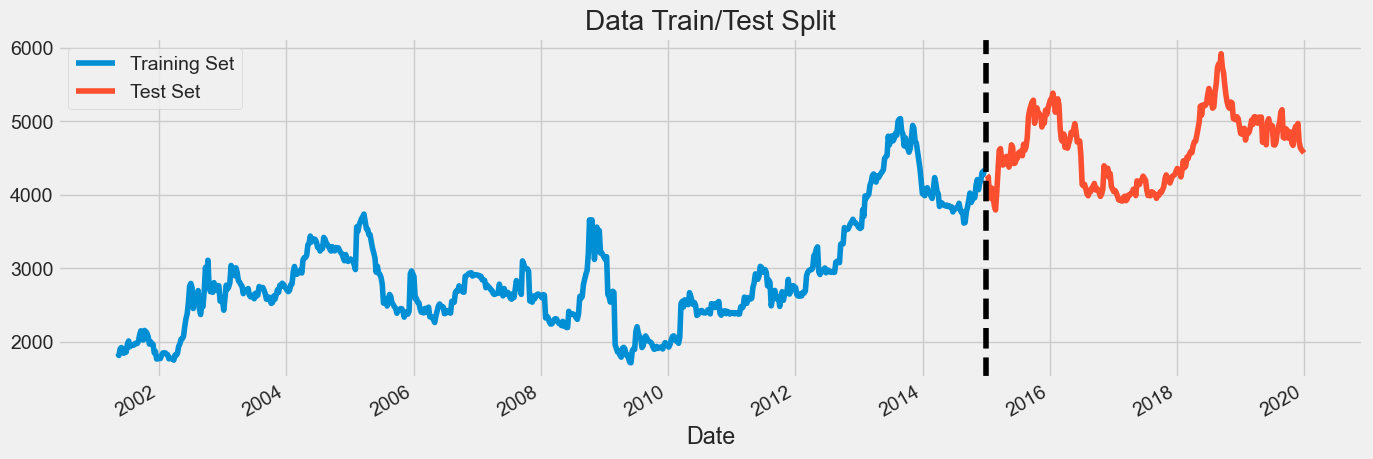

In [79]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2014-12-31', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [80]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Visualize our Feature / Target Relationship¶


C:\Users\Denil\AppData\Local\Temp\ipykernel_3320\3576372623.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='target', palette='Blues')


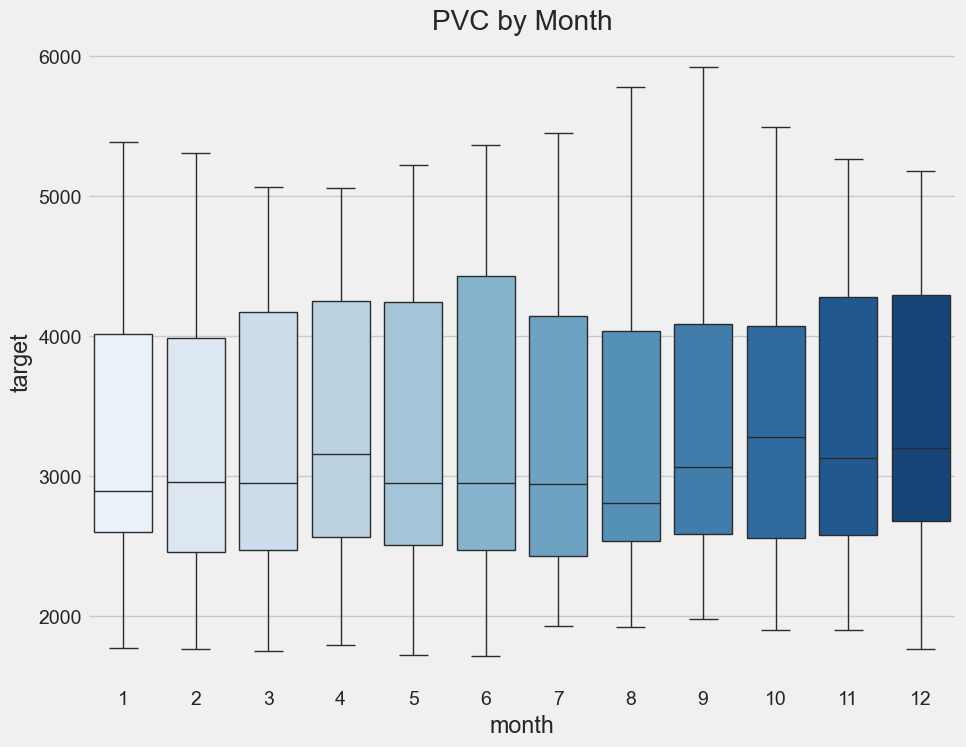

In [81]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='target', palette='Blues')
ax.set_title('PVC by Month')
plt.show()

In [82]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'target'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [83]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2915.41345	validation_1-rmse:4614.28144
[100]	validation_0-rmse:1120.41090	validation_1-rmse:2125.98891
[200]	validation_0-rmse:493.17027	validation_1-rmse:1262.67655


C:\Users\Denil\anaconda3\envs\xgboost\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:24:06] WARNING: D:\bld\xgboost-split_1705650090842\work\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:306.14943	validation_1-rmse:975.41800
[400]	validation_0-rmse:255.57560	validation_1-rmse:876.08809
[500]	validation_0-rmse:238.47067	validation_1-rmse:844.75692
[600]	validation_0-rmse:227.12758	validation_1-rmse:832.63181
[700]	validation_0-rmse:217.31666	validation_1-rmse:828.72923
[800]	validation_0-rmse:203.50593	validation_1-rmse:826.63105
[900]	validation_0-rmse:199.28406	validation_1-rmse:824.96964
[999]	validation_0-rmse:195.76956	validation_1-rmse:823.30041


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance¶


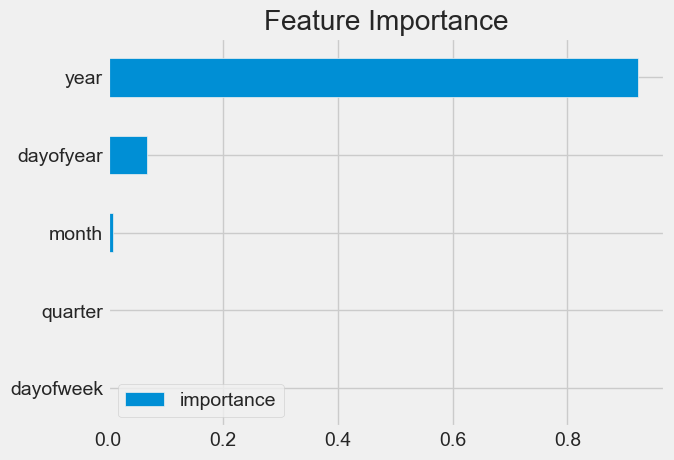

In [84]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test¶


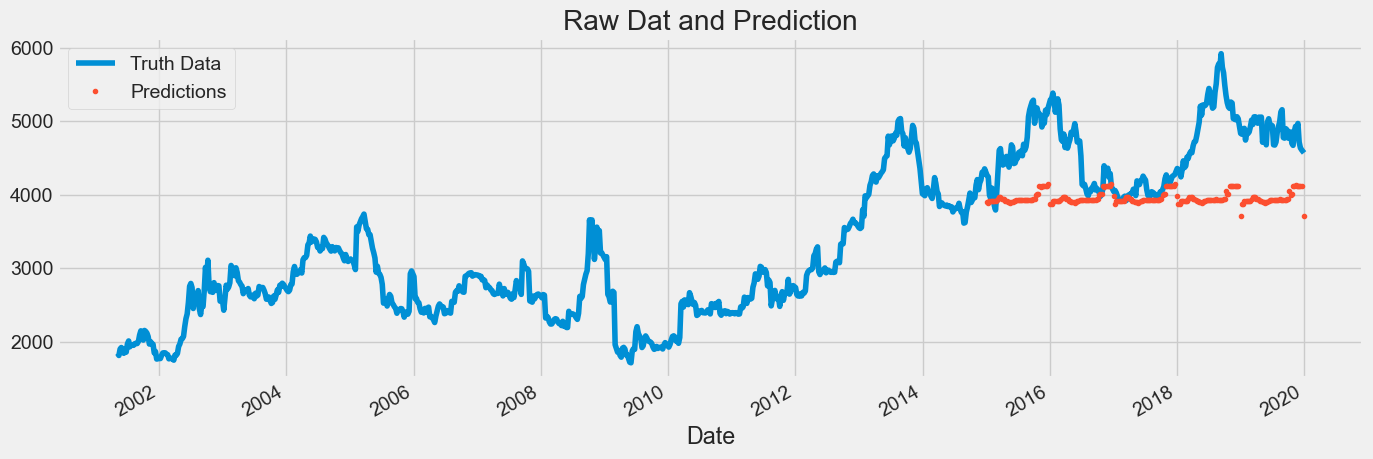

In [85]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['target']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()